## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Now, we read in the `ab_data.csv` data. Store it in `df`.

Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [7]:
a = df.query('group == "treatment" & landing_page == "new_page"').copy()
b = df.query('group == "treatment" | landing_page == "new_page"').copy()

In [8]:
b.shape[0] - a.shape[0]

3893

Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

Store your new dataframe in **df2**.

In [10]:
df2 = df.query('(group == "treatment" & landing_page == "new_page") | (group == "control" & landing_page == "old_page")').copy()


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

__Duplicated rows__

In [13]:
df2[df2.user_id.duplicated(keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removing **one** of the rows with a duplicate **user_id**, but we'll keep our dataframe as **df2**.

In [14]:
df2.drop(labels = 2893,axis = 0,inplace = True)

In [15]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted




What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

What is the probability that an individual received the new page?

In [19]:
(df2['landing_page'] == "new_page").mean()

0.50006194422266881

__Till now there is no conclusive evidence that one page leads to more conversion than the other since in the given data set the probabilities of either group getting converted are almost the same.__

<a id='ab_test'></a>
### Part II - A/B Test



`1.` Considering we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?

$H_0 : p_{old} - p_{new} \geq 0$

$H_1 : p_{old} - p_{new} < 0$

`2.` Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
df2.converted.mean()

0.11959708724499628

What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
df2.converted.mean()

0.11959708724499628

What is $n_{new}$?

In [22]:
df2.query('landing_page == "new_page"').shape[0]

145310

In [23]:
df_new = df2.query('landing_page == "new_page"')

What is $n_{old}$?

In [24]:
df2.query('landing_page == "old_page"').shape[0]

145274

In [25]:
df_old = df2.query('landing_page == "old_page"')

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.binomial(1,df2.converted.mean(),size = 145310)

In [27]:
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.binomial(1,df2.converted.mean(),size = 145274)

In [29]:
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{old}$ - $p_{new}$ for your simulated values from part (e) and (f).

In [30]:
old_page_converted.mean() - new_page_converted.mean()

0.003037383229147414

Simulating 10,000 $p_{old}$ - $p_{new}$ values. Storing all 10,000 values in **p_diffs**.

In [31]:
p_diffs = []
for _ in np.arange(10000):
    old = np.random.binomial(1,df2.converted.mean(),size = 145274)
    new = np.random.binomial(1,df2.converted.mean(),size = 145310)
    diff = old.mean() - new.mean()
    p_diffs.append(diff)
p_diffs = pd.Series(p_diffs)


Plotting a histogram of the **p_diffs**.

In [32]:
statistic = df_old.converted.mean() - df_new.converted.mean()

In [33]:
statistic

0.0015782389853555567

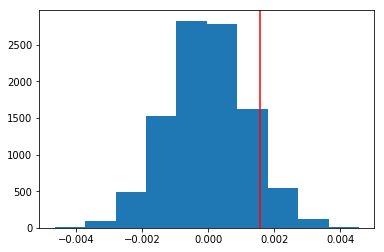

In [34]:
plt.hist(p_diffs);
plt.axvline(statistic,color = 'r');

What proportion of the **p_diffs** are smaller than the actual difference observed in **ab_data.csv**?

In [35]:
(p_diffs < statistic).mean()

0.90110000000000001

**We computed the proportion of values in series p_diffs which are less than our statistic($p_{old} - p_{new}$), this is called p value in scientific studies and since p value we obtained is greater than the 5% type 1 error rate i.e greater than 0.05, we can say that we fail to reject the null hypothesis and hence we can say that the new page is not better than the old page.**

In [36]:
import statsmodels.api as sm

convert_old = df_old.converted.sum()
convert_new = df_new.converted.sum()
n_old = df_old.shape[0]
n_new = df_new.shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now we'll use `stats.proportions_ztest` to compute our test statistic and p-value.

In [37]:
z_score, p_value = sm.stats.proportions_ztest([df_old.converted.sum(),df_new.converted.sum()],[145274,145310],alternative = 'smaller')

In [38]:
p_value

0.90505831275902449

In [39]:
z_score

1.3109241984234394

In [40]:
from scipy.stats import norm

In [41]:
norm.cdf(z_score)

0.90505831275902449

In [42]:
norm.ppf(1-0.05/2)


1.959963984540054

In [43]:
z_score > norm.ppf(1-0.05/2)

False

**Since our p value is greater than the 95% type error rate i.e 0.05, we fail to reject the null hypothesis which suggests that the old page is better or equally good to the new page or we can also say that sinc eour z_score is not greater than the critical value at 95% confidence we fail to reject the null hypothesis .**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>



**Since the response variable is categorical we will use the logistic regression.**

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [44]:
df2['intercept'] = 1

In [45]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [46]:
df2[['control','treatment']] = pd.get_dummies(df2['group'])

In [47]:
df2.drop('control',inplace = True,axis = 1)

In [48]:
df2.rename(columns = {'treatment':'ab_page'},inplace = True)

Using **statsmodels** to import our regression model.  Instantiate the model, and fit the model and  to predict whether or not an individual converts.

In [49]:
import statsmodels.api as sm

In [50]:
reg = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
reg = reg.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [51]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:               8.077e-06
Time:                        11:21:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

What is the p-value associated with **ab_page**? Why does it differ from the value we found in the **Part II**?<br><br>  


**p_value associated with the ab_page is 0.190, it differs from the value we found in part 2 because the summary that we obtain from fitting the logistic model is based on a two tailed test on whether or not the slope of the parameter is zero or non zero, but in the case above we have defined our hypotheses in a way that which is one tailed unlike the one in the logistic regression model. Since the p_value is greater than the 95% type 1 error rate we can say that we can't reject the null hypotheses of the logistic model and hence the type of page is not significant in deciding the outcome of whether converted or not**

Now along with testing if the conversion rate changes for different pages, we also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together our datasets on the approporiate rows.

In [52]:
df_countries = pd.read_csv('./countries.csv')

In [53]:
df_final = df2.merge(df_countries,how = 'inner',on = 'user_id')

In [54]:
df_final.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [55]:
df_final[['CA','UK','US']] = pd.get_dummies(df_final['country'])

In [59]:
reg_new = sm.Logit(df_final['converted'],df_final[['intercept','UK','US']])
reg_new = reg_new.fit()
reg_new.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:               1.521e-05
Time:                        11:41:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

__As we can see in the above summary that p value for both UK and US are greater than 5% type 1 error rate i.e 0.05, so fail to reject the null and hence we can say that countries also don't have the statistical significance and are not deciding factors whether or not a user is likely to get converted.__

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there is significant effects on conversion. We'll create the necessary additional columns, and fit the new model.  

In [63]:
df_final.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1


In [68]:
df_final['page_CA'] = df_final['ab_page']*df_final['CA']
df_final['page_UK'] = df_final['ab_page']*df_final['UK']
df_final['page_US'] = df_final['ab_page']*df_final['US']

In [70]:
a = sm.Logit(df_final['converted'],df_final[['intercept','ab_page','UK','US','page_UK','page_US']])
a = a.fit()
a.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 01 Jun 2018   Pseudo R-squ.:               3.482e-05
Time:                        12:33:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
page_UK        0.0783      0.057      1.378      0.168      -0.033       0.190
page_US        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

__Looking at the summary above we can see that the p values associated with the interaction terms is greater than 5% type 1 error rate and hence we can't reject the null in that case which states that coefficient for interaction terms is 0 which signifies that interaction terms of ab_page and countries don't bear a statistical significance in the output i.e getting converted or not.__